# Getting started with normative modelling

Welcome to this tutorial notebook that will show you the very basics of normative modeling. It's like the "Hello World" of normative modeling.

Let's jump right in.

### Imports

In [1]:
import warnings
import pandas as pd
import matplotlib.pyplot as plt
from pcntoolkit import (
    BLR,
    NormativeModel,
    NormData,
    load_fcon1000,
    plot_centiles,
    plot_qq,
)
import pcntoolkit.util.output
import seaborn as sns

sns.set_style("darkgrid")
warnings.simplefilter(action="ignore", category=FutureWarning)
pd.options.mode.chained_assignment = None  # default='warn'
pcntoolkit.util.output.Output.set_show_messages(False)

## Load data

First we download a small example dataset from github.

In [2]:
# Download an example dataset
norm_data: NormData = load_fcon1000()
# Select only these three features to model for this example
norm_data = norm_data.sel({"response_vars": ["WM-hypointensities", "Left-Lateral-Ventricle", "Brain-Stem"]})
# Train-test split
train, test = norm_data.train_test_split()

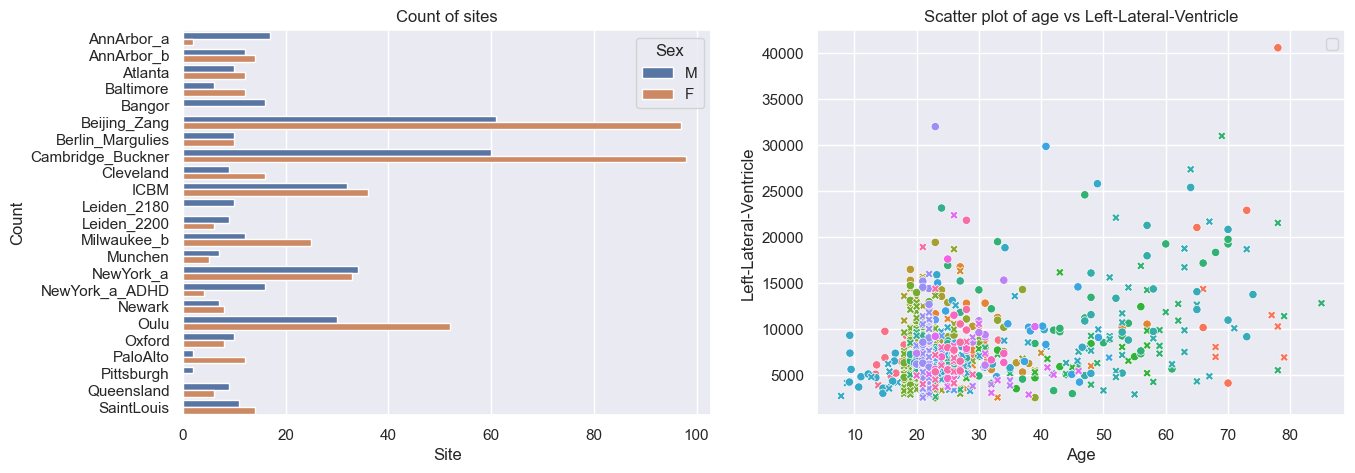

In [3]:
# Inspect the data
df = train.to_dataframe()
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.countplot(data=df, y=("batch_effects", "site"), hue=("batch_effects", "sex"), ax=ax[0], orient="h")
ax[0].legend(title="Sex")
ax[0].set_title("Count of sites")
ax[0].set_xlabel("Site")
ax[0].set_ylabel("Count")

scatter_feature = "Left-Lateral-Ventricle"

sns.scatterplot(
    data=df,
    x=("X", "age"),
    y=("Y", scatter_feature),
    hue=("batch_effects", "site"),
    style=("batch_effects", "sex"),
    ax=ax[1],
)
ax[1].legend([], [])
ax[1].set_title(f"Scatter plot of age vs {scatter_feature}")
ax[1].set_xlabel("Age")
ax[1].set_ylabel(scatter_feature)

plt.show()

## Creating a Normative model


In [4]:
save_dir = "/Users/stijndeboer/Projects/PCN/PCNtoolkit/examples/saves"
model = NormativeModel(BLR(), inscaler="standardize", outscaler="standardize")

In [5]:
model.has_batch_effect

False

## Fit the model


With all that configured, we can fit the model. 

The `fit_predict` function will fit the model, evaluate it, save the results and plots, and return the test data with all the predictions added. 

After that, it will compute Z-scores and centiles for the test set. 

All results can be found in the save directory. 

In [6]:
model.fit_predict(train, test)

<xarray.NormData> Size: 87kB
Dimensions:            (observations: 216, response_vars: 3, covariates: 1,
                        batch_effect_dims: 2, centile: 5, statistic: 11)
Coordinates:
  * observations       (observations) int64 2kB 756 769 692 616 ... 751 470 1043
  * response_vars      (response_vars) <U22 264B 'WM-hypointensities' ... 'Br...
  * covariates         (covariates) <U3 12B 'age'
  * batch_effect_dims  (batch_effect_dims) <U4 32B 'sex' 'site'
  * centile            (centile) float64 40B 0.05 0.25 0.5 0.75 0.95
  * statistic          (statistic) <U8 352B 'EXPV' 'MACE' ... 'SMSE' 'ShapiroW'
Data variables:
    subject_ids        (observations) object 2kB 'Munchen_sub96752' ... 'Quee...
    Y                  (observations, response_vars) float64 5kB 2.721e+03 .....
    X                  (observations, covariates) float64 2kB 63.0 ... 23.0
    batch_effects      (observations, batch_effect_dims) <U17 29kB 'F' ... 'Q...
    Z                  (observations, response_vars) float64 5kB 0.8681 ... -...
    centiles           (centile, observations, response_vars) float64 26kB 75...
    logp               (observations, response_vars) float64 5kB -1.254 ... -...
    Yhat               (observations, response_vars) float64 5kB 2.041e+03 .....
    statistics         (response_vars, statistic) float64 264B 0.1501 ... 0.9891
    Y_harmonized       (observations, response_vars) float64 5kB 2.721e+03 .....
Attributes:
    real_ids:                       True
    is_scaled:                      False
    name:                           fcon1000_test
    unique_batch_effects:           {np.str_('sex'): [np.str_('F'), np.str_('...
    batch_effect_counts:            defaultdict(<function NormData.register_b...
    covariate_ranges:               {np.str_('age'): {'mean': np.float64(28.2...
    batch_effect_covariate_ranges:  {np.str_('sex'): {np.str_('F'): {np.str_(...

## Plotting the centiles
With the fitted model, and some data, we can plot some centiles. There are a lot of different configurations possible, but here is a simple example. 

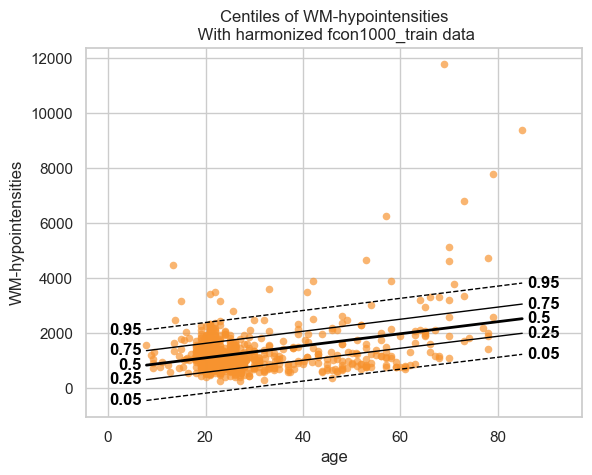

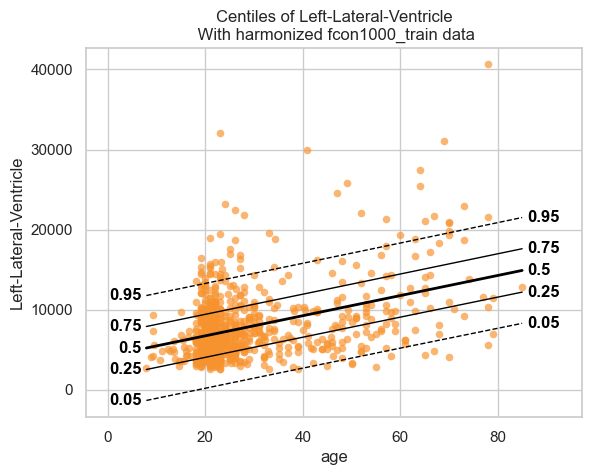

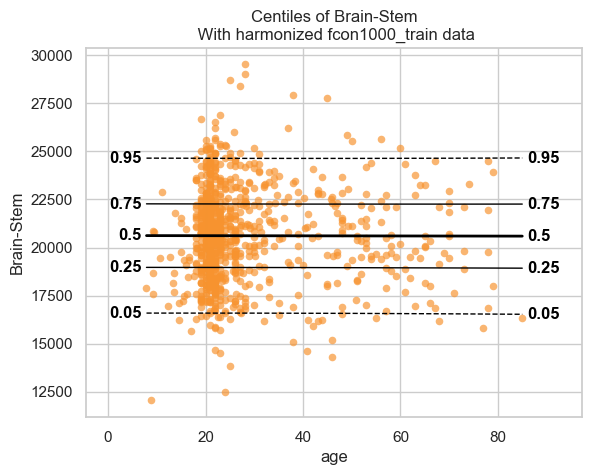

In [7]:
plot_centiles(model, scatter_data=train)

We see that the model fits the data reasonably well. We can do better, but that is a topic for another tutorial.

### Showing the evaluation metrics

We also computed evaluation metrics for the model. Those are saved in the `save_dir/results/statistics.csv` file, but are also added to the NormData object as a new data variable.


In [8]:
# We can use the `get_statistics_df` method to get a nicely formatted dataframe with the evaluation metrics.
display(train.get_statistics_df())
display(test.get_statistics_df())

statistic,EXPV,MACE,MAPE,MSLL,NLL,R2,RMSE,Rho,Rho_p,SMSE,ShapiroW
response_vars,,,,,,,,,,,
Brain-Stem,0.000004,0.006311,0.096330,-7.800671,1.418910,0.000004,2442.168242,-0.050426,1.390658e-01,0.999996,0.996466
Left-Lateral-Ventricle,0.162276,0.053828,0.401734,-8.440148,1.330158,0.162276,3877.069187,0.269669,7.905570e-16,0.837724,0.877568
WM-hypointensities,0.132905,0.068724,0.410158,-6.778665,1.345555,0.132905,760.501165,0.019769,5.621687e-01,0.867095,0.722254


statistic,EXPV,MACE,MAPE,MSLL,NLL,R2,RMSE,Rho,Rho_p,SMSE,ShapiroW
response_vars,,,,,,,,,,,
Brain-Stem,-0.000274,0.014259,0.103240,-7.790895,1.525974,-0.000309,2692.120004,-0.105739,0.121292,1.000309,0.989058
Left-Lateral-Ventricle,0.175440,0.046296,0.430686,-8.443777,1.404512,0.171542,4168.272079,0.220610,0.001099,0.828458,0.898344
WM-hypointensities,0.150136,0.060741,0.444148,-6.693763,1.130787,0.143994,559.964146,-0.027495,0.687809,0.856006,0.972405


### QQ plots

We also have a nice function to make QQ plots.


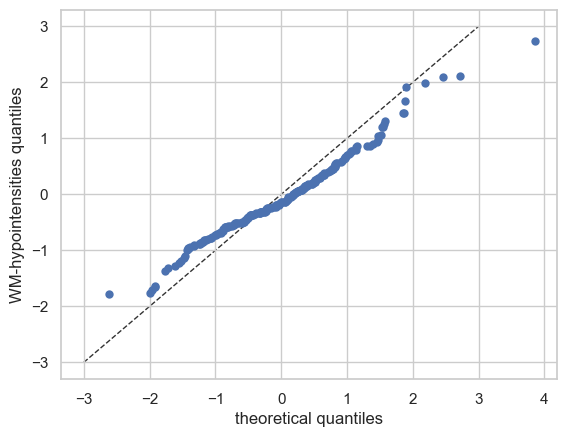

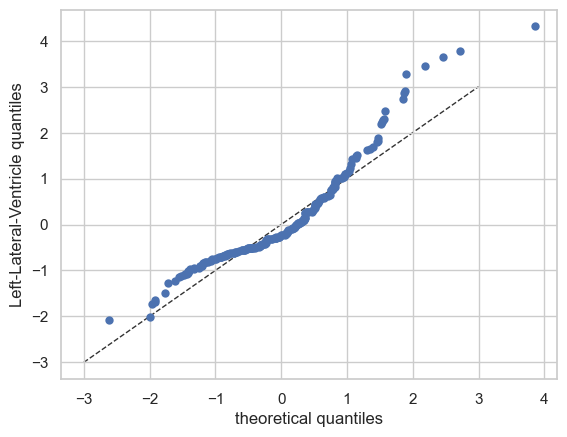

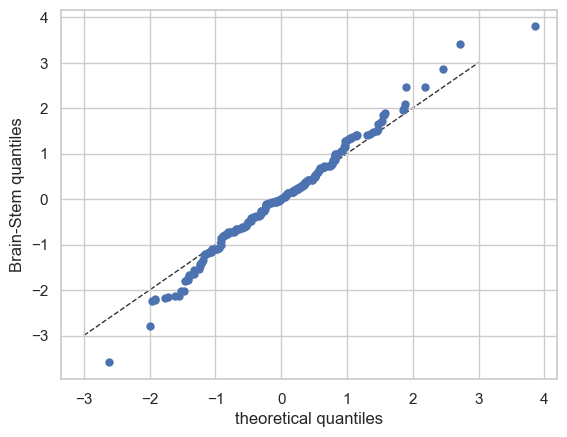

In [9]:
plot_qq(test, plot_id_line=True)

And those are the basics of Normative Modelling with the PCNtoolkit. We will go over some more advanced models in the next tutorials, but this should give you a good first impression.